### PIPELINE OVERVIEW

----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [445]:
from multidimvis_main import *

_____
# 1 | SELECT ONE NETWORK GRAPH
_____

In [3]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)
G = G_cere

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k[22:])
    
df_gID_sym = pd.read_csv('input/Yeast_geneID_sym.csv', index_col=0)
gene_sym = list(df_gID_sym['Sym'])
gene_id = list(df_gID_sym.index)
g_ID_sym = dict(list(zip(gene_id, gene_sym)))
#len(g_ID_sym)
    
l_features = []
for i in g_ID_sym.values():
    l_features.append(i)

In [446]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

#df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
#l_features = list((df_gene_sym.to_dict()).values())

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k)
    
# Gene Symbols 
df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
l_features = list(df_gene_sym['0'])

In [447]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


_____
# 2 | LOAD AND SELECT ONF OF THE FOLLOWING DISTANCE MATRICES
_____

### + STRUCTURAL : Graph structure based
+ Adjacency
+ Random Walk with Restart
+ Centrality measures

#### IMPORT PRECALCULATED 

In [1442]:
DM_adj = pd.read_csv('_output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)
DM_adj.index = list(G.nodes())
DM_adj.columns = list(G.nodes())

DM_adj

,entrez gene/locuslink:853056,entrez gene/locuslink:850930,entrez gene/locuslink:854123,entrez gene/locuslink:856771,entrez gene/locuslink:851205,entrez gene/locuslink:851882,entrez gene/locuslink:854540,entrez gene/locuslink:855599,entrez gene/locuslink:850693,entrez gene/locuslink:851455,...,entrez gene/locuslink:9164927,entrez gene/locuslink:55689,entrez gene/locuslink:4300,entrez gene/locuslink:5578,biogrid:32279,biogrid:32106,entrez gene/locuslink:2540578,entrez gene/locuslink:851514,entrez gene/locuslink:856436,entrez gene/locuslink:947286
entrez gene/locuslink:853056,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:850930,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:854123,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:856771,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:851205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
biogrid:32106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:2540578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:851514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrez gene/locuslink:856436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
DM_m_visprob = pd.read_csv('_output_csv/RWR_visitingprob_Dataframe_'+organism+'.csv', index_col=0)
DM_m_visprob.index = list(G.nodes())
DM_m_visprob.columns = list(G.nodes())

DM_m_visprob

In [1443]:
DM_m = pd.read_csv('_output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)
DM_m.index = list(G.nodes())
DM_m.columns = list(G.nodes())

DM_m

,entrez gene/locuslink:853056,entrez gene/locuslink:850930,entrez gene/locuslink:854123,entrez gene/locuslink:856771,entrez gene/locuslink:851205,entrez gene/locuslink:851882,entrez gene/locuslink:854540,entrez gene/locuslink:855599,entrez gene/locuslink:850693,entrez gene/locuslink:851455,...,entrez gene/locuslink:9164927,entrez gene/locuslink:55689,entrez gene/locuslink:4300,entrez gene/locuslink:5578,biogrid:32279,biogrid:32106,entrez gene/locuslink:2540578,entrez gene/locuslink:851514,entrez gene/locuslink:856436,entrez gene/locuslink:947286
entrez gene/locuslink:853056,0.000000,0.987106,1.000000,1.000000,0.999997,1.000000,0.999999,1.000000,1.000000,0.999999,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
entrez gene/locuslink:850930,0.987106,0.000000,0.999999,0.999997,0.999967,0.999999,0.999997,1.000000,0.999999,0.999999,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
entrez gene/locuslink:854123,1.000000,0.999999,0.000000,0.990527,0.994592,0.999607,0.999950,0.999994,0.999147,0.999994,...,0.999998,1.000000,1.000000,1.0,0.999996,0.999998,1.0,1.000000,0.999999,0.999987
entrez gene/locuslink:856771,1.000000,0.999997,0.990527,0.000000,0.999934,0.999996,0.999921,0.999999,0.999992,0.999999,...,0.999997,1.000000,1.000000,1.0,0.999997,1.000000,1.0,1.000000,0.999999,0.998991
entrez gene/locuslink:851205,0.999997,0.999967,0.994592,0.999934,0.000000,0.999994,0.999999,1.000000,0.999996,0.999957,...,1.000000,0.999999,0.999999,1.0,0.999998,0.999996,1.0,0.999996,0.999999,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
biogrid:32106,1.000000,1.000000,0.999998,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,0.999997,0.000000,1.0,1.000000,1.000000,1.000000
entrez gene/locuslink:2540578,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000
entrez gene/locuslink:851514,1.000000,1.000000,1.000000,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000
entrez gene/locuslink:856436,1.000000,1.000000,0.999999,0.999999,0.999999,1.000000,1.000000,0.999998,1.000000,0.999999,...,1.000000,0.999983,0.999983,1.0,1.000000,1.000000,1.0,1.000000,0.000000,1.000000


In [225]:
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

In [216]:
DM_centralities = round(DM_centralities,4)
DM_centralities.index = list(G.nodes())
DM_centralities.columns = list(G.nodes())

DM_centralities

,entrez gene/locuslink:853056,entrez gene/locuslink:850930,entrez gene/locuslink:854123,entrez gene/locuslink:856771,entrez gene/locuslink:851205,entrez gene/locuslink:851882,entrez gene/locuslink:854540,entrez gene/locuslink:855599,entrez gene/locuslink:850693,entrez gene/locuslink:851455,...,entrez gene/locuslink:9164927,entrez gene/locuslink:55689,entrez gene/locuslink:4300,entrez gene/locuslink:5578,biogrid:32279,biogrid:32106,entrez gene/locuslink:2540578,entrez gene/locuslink:851514,entrez gene/locuslink:856436,entrez gene/locuslink:947286
entrez gene/locuslink:853056,0.0000,0.0092,0.0100,0.0005,0.0292,0.0000,0.0000,0.0002,0.0015,0.0002,...,0.0014,0.0032,0.0032,0.0032,0.0032,0.0032,0.0031,0.0032,0.0003,0.0032
entrez gene/locuslink:850930,0.0092,0.0000,0.0005,0.0059,0.0103,0.0103,0.0098,0.0118,0.0181,0.0112,...,0.0178,0.0233,0.0233,0.0232,0.0233,0.0233,0.0229,0.0232,0.0125,0.0233
entrez gene/locuslink:854123,0.0100,0.0005,0.0000,0.0062,0.0066,0.0113,0.0105,0.0127,0.0190,0.0116,...,0.0188,0.0242,0.0242,0.0241,0.0241,0.0242,0.0238,0.0241,0.0135,0.0242
entrez gene/locuslink:856771,0.0005,0.0059,0.0062,0.0000,0.0223,0.0008,0.0006,0.0012,0.0035,0.0009,...,0.0034,0.0060,0.0060,0.0059,0.0059,0.0060,0.0058,0.0059,0.0014,0.0060
entrez gene/locuslink:851205,0.0292,0.0103,0.0066,0.0223,0.0000,0.0315,0.0296,0.0334,0.0417,0.0303,...,0.0416,0.0483,0.0483,0.0485,0.0483,0.0485,0.0482,0.0485,0.0347,0.0486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
biogrid:32106,0.0032,0.0233,0.0242,0.0060,0.0485,0.0027,0.0029,0.0020,0.0003,0.0023,...,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0017,0.0000
entrez gene/locuslink:2540578,0.0031,0.0229,0.0238,0.0058,0.0482,0.0025,0.0028,0.0019,0.0003,0.0022,...,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0016,0.0000
entrez gene/locuslink:851514,0.0032,0.0232,0.0241,0.0059,0.0485,0.0026,0.0029,0.0020,0.0003,0.0023,...,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0017,0.0000
entrez gene/locuslink:856436,0.0003,0.0125,0.0135,0.0014,0.0347,0.0001,0.0002,0.0000,0.0005,0.0002,...,0.0005,0.0017,0.0017,0.0017,0.0017,0.0017,0.0016,0.0017,0.0000,0.0017


### + FUNCTIONAL : Molecular Function

#### IMPORT PRECALCULATED 

In [8]:
# Feature Matrix loaded 
Feature_MF = pd.read_csv('_output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)

In [9]:
Feature_MF

,GO:0000010,GO:0000014,GO:0000016,GO:0000026,GO:0000030,GO:0000033,GO:0000035,GO:0000036,GO:0000048,GO:0000049,...,GO:1990837,GO:1990841,GO:1990883,GO:1990930,GO:1990931,GO:1990948,GO:1990955,GO:1990984,GO:2001065,GO:2001069
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107987462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107987491,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109703458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110117499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
DM_MF = pd.read_csv('_output_csv/DistanceMatrix_goMF_Dataframe_Human_cosine.csv', index_col=0)

DM_MF_mod = DM_MF.round(decimals=4)

In [11]:
DM_MF = DM_MF_mod

In [12]:
round(DM_MF,2)

,2,9,10,12,13,14,15,16,18,19,...,102724159,102724334,102724428,102724862,105371242,107987462,107987491,109703458,110117499,110599564
2,0.00,1.00,0.79,0.65,1.0,1.0,0.79,1.0,1.0,0.86,...,1.0,1.00,1.0,0.79,1.0,0.85,0.85,1.0,1.0,1.0
9,1.00,0.00,0.29,1.00,1.0,1.0,1.00,1.0,1.0,1.00,...,1.0,1.00,1.0,1.00,1.0,1.00,1.00,1.0,1.0,1.0
10,0.79,0.29,0.00,0.59,1.0,1.0,0.50,1.0,1.0,0.83,...,1.0,1.00,1.0,1.00,1.0,0.65,0.65,1.0,1.0,1.0
12,0.65,1.00,0.59,0.00,1.0,1.0,0.59,1.0,1.0,0.86,...,1.0,0.42,1.0,1.00,1.0,0.71,0.71,1.0,1.0,1.0
13,1.00,1.00,1.00,1.00,0.0,1.0,1.00,1.0,1.0,1.00,...,1.0,1.00,1.0,1.00,1.0,1.00,1.00,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107987462,0.85,1.00,0.65,0.71,1.0,1.0,0.65,1.0,1.0,0.88,...,1.0,1.00,1.0,1.00,1.0,0.00,0.75,1.0,1.0,1.0
107987491,0.85,1.00,0.65,0.71,1.0,1.0,0.65,1.0,1.0,0.88,...,1.0,1.00,1.0,1.00,1.0,0.75,0.00,1.0,1.0,1.0
109703458,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.0,1.0,1.00,...,1.0,1.00,1.0,1.00,1.0,1.00,1.00,0.0,1.0,1.0
110117499,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.0,1.0,1.00,...,1.0,1.00,1.0,1.00,1.0,1.00,1.00,1.0,0.0,1.0


### + FUNCTIONAL : Cellular Components

#### IMPORT PRECALCULATED 

In [13]:
DM_CC = pd.read_csv('_output_csv/DistanceMatrix_goCC_Dataframe_Human_cosine.csv', index_col=0)

DM_CC_mod = DM_CC.round(decimals=4)

In [14]:
DM_CC = DM_CC_mod

In [15]:
DM_CC

,1,2,9,10,12,13,14,15,16,18,...,102724159,102724334,102724428,105371242,107983988,107984208,107987462,107987491,109703458,110117499
1,0.0000,0.3675,1.0000,1.0000,0.2929,1.0,1.0000,1.0000,0.8419,1.0000,...,1.0,0.8232,1.0000,1.0000,1.0,0.6464,1.0,1.0000,1.0000,1.0
2,0.3675,0.0000,0.5528,0.5528,0.4037,1.0,0.7764,0.7418,0.6000,1.0000,...,1.0,0.7764,1.0000,1.0000,1.0,1.0000,1.0,0.8174,1.0000,1.0
9,1.0000,0.5528,0.0000,0.0000,1.0000,1.0,0.5000,0.4226,0.5528,1.0000,...,1.0,0.5000,1.0000,1.0000,1.0,1.0000,1.0,0.5918,1.0000,1.0
10,1.0000,0.5528,0.0000,0.0000,1.0000,1.0,0.5000,0.4226,0.5528,1.0000,...,1.0,0.5000,1.0000,1.0000,1.0,1.0000,1.0,0.5918,1.0000,1.0
12,0.2929,0.4037,1.0000,1.0000,0.0000,1.0,1.0000,1.0000,0.8509,1.0000,...,1.0,0.6667,0.8075,1.0000,1.0,0.6667,1.0,0.8639,1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107984208,0.6464,1.0000,1.0000,1.0000,0.6667,1.0,1.0000,1.0000,1.0000,1.0000,...,1.0,0.5000,1.0000,1.0000,1.0,0.0000,1.0,1.0000,1.0000,1.0
107987462,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,...,1.0,1.0000,1.0000,1.0000,1.0,1.0000,0.0,1.0000,1.0000,1.0
107987491,1.0000,0.8174,0.5918,0.5918,0.8639,1.0,0.7959,0.7643,0.8174,1.0000,...,1.0,0.3876,0.7643,1.0000,1.0,1.0000,1.0,0.0000,0.7643,1.0
109703458,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,0.7418,0.3333,...,1.0,1.0000,1.0000,0.4226,1.0,1.0000,1.0,0.7643,0.0000,1.0


### + FUNCTIONAL : Biological Processes

#### IMPORT PRECALCULATED 

In [16]:
DM_BP = pd.read_csv('_output_csv/DistanceMatrix_goBP_Dataframe_Human_cosine.csv', index_col=0)
    
DM_BP_mod = DM_BP.round(decimals=4)

In [17]:
DM_BP = DM_BP_mod

In [706]:
DM_BP

,1,2,9,10,12,13,14,15,16,18,...,102724862,105372315,105373297,105375355,105377641,107983988,107987462,107987491,109703458,110117499
1,0.0000,0.6838,1.0,1.0,0.4226,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.6464,1.0,1.0,1.0
2,0.6838,0.0000,1.0,1.0,0.8174,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0
9,1.0000,1.0000,0.0,0.0,1.0000,0.2929,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0
10,1.0000,1.0000,0.0,0.0,1.0000,0.2929,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0
12,0.4226,0.8174,1.0,1.0,0.0000,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.7959,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107983988,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0000,1.0,1.0,1.0
107987462,0.6464,1.0000,1.0,1.0,0.7959,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,1.0,1.0,1.0
107987491,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,0.0,1.0,1.0
109703458,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.0,1.0


### + FUNCTIONAL : Disease Annotation

#### IMPORT PRECALCULATED 

In [19]:
DM_Disease = pd.read_csv('_output_csv/DistanceMatrix_Disease_Dataframe_Human_cosine.csv', index_col=0)
    
DM_Disease_mod = DM_Disease.round(decimals=4)

In [20]:
DM_Disease = DM_Disease_mod

In [21]:
DM_Disease

,389289,4524,4353,27127,5925,10735,26259,1029,9649,1630,...,65125,6787,90678,10661,56479,63910,7287,11173,9962,5973
389289,0.0000,0.8360,0.7474,0.0000,0.7809,0.4380,0.0000,0.8075,0.0000,0.6349,...,0.9167,0.8174,0.9512,0.8946,0.8557,0.8333,0.9519,0.8557,0.8457,0.9385
4524,0.8360,0.0000,0.5027,0.8360,0.7065,0.8003,0.8360,0.7422,0.8360,0.8103,...,0.8086,0.8503,0.9680,0.8963,0.8579,0.8633,0.8343,0.8343,0.8988,0.9596
4353,0.7474,0.5027,0.0000,0.7474,0.7509,0.8580,0.7474,0.7893,0.7474,0.8309,...,0.7474,0.8155,0.9630,0.9201,0.8906,0.7895,0.8906,0.8177,0.8441,0.9378
27127,0.0000,0.8360,0.7474,0.0000,0.7809,0.4380,0.0000,0.8075,0.0000,0.6349,...,0.9167,0.8174,0.9512,0.8946,0.8557,0.8333,0.9519,0.8557,0.8457,0.9385
5925,0.7809,0.7065,0.7509,0.7809,0.0000,0.7127,0.7809,0.5784,0.7809,0.8000,...,0.9087,0.9200,0.9679,0.9307,0.8103,0.8174,0.8630,0.8735,0.9324,0.9595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63910,0.8333,0.8633,0.7895,0.8333,0.8174,0.9063,0.8333,0.8717,0.8333,0.9391,...,0.8333,0.8174,0.9024,0.7892,0.7113,0.0000,0.9038,0.7113,0.6914,0.8769
7287,0.9519,0.8343,0.8906,0.9519,0.8630,0.9730,0.9519,0.9074,0.9519,0.9649,...,0.8797,0.8946,0.9296,0.9391,0.6667,0.9038,0.0000,0.8750,0.9109,0.9645
11173,0.8557,0.8343,0.8177,0.8557,0.8735,0.9189,0.8557,0.9444,0.8557,0.9473,...,0.6392,0.8419,0.9155,0.8174,0.7500,0.7113,0.8750,0.0000,0.7327,0.8401
9962,0.8457,0.8988,0.8441,0.8457,0.9324,0.9133,0.8457,0.9109,0.8457,0.9437,...,0.8457,0.8310,0.9096,0.8048,0.7327,0.6914,0.9109,0.7327,0.0000,0.8860


### Linkage / Dendogram

In [ ]:
'''
Generate a heatmap + Dendogramm from a Matrix.
Return plot.
'''
def heatmap_from_matrix(Matrix, title = None):

    # Dendogramm
    fig = pylab.figure(figsize=(12,8))

    axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
    Y = sch.linkage(Matrix, method='average')
    Z = sch.dendrogram(Y, orientation='left')
    axdendro.set_xticks([])
    axdendro.set_yticks([])


    # Plot distance 
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    index = Z['leaves']
    Dsq = Matrix
    Dsq = Dsq[index,:]
    Dsq = Dsq[:,index]
    im = axmatrix.matshow(Dsq, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])


    # Plot colorbar
    plt.title(title, fontsize= 20)
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)
    
    plt.savefig('output_plots/' + title + '.png')

    
    return plt.show()

_____
### SELECT THE DISTANCE MATRIX

In [ ]:
#---------------
# STRUCTURAL
#---------------
#feature = 'adj'
#DM = DM_adj

feature = 'rwr'
DM = DM_m_visprob
#DM = DM_m

#feature = 'centralities'
#DM = DM_centralities


#---------------
# FUNCTIONAL 
#---------------

#feature = 'bioproc'
#DM = DM_BP
#feat_matrix = pd.read_csv('_output_csv/Features_GO_BiolProc_Dataframe_Human.csv', index_col=0)
#d_goid_genes = pickle.load( open( "input/celine/d_go2ent_incUpstream_bioprocesses_s20200707.pkl", "rb" ) )

#feature = 'molfunc'
#DM = DM_MF
#feat_matrix = pd.read_csv('_output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)
#d_goid_genes = pickle.load( open( "input/celine/d_go2ent_incUpstream_molfunc_s20200707.pkl", "rb" ) )

#feature = 'cellcomp'
#DM = DM_CC
#feat_matrix = pd.read_csv('_output_csv/Features_GO_CellComp_Dataframe_Human.csv', index_col=0)
#d_goid_genes = pickle.load( open( "input/celine/d_go2ent_incUpstream_cellcomp_s20200707.pkl", "rb" ) )

#feature = 'disease'
#DM = DM_Disease
#feat_matrix = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)
#d_doid_genes = pickle.load(open("input/celine/d_doid2ent_incUpstream5to100_s20200707.pkl", "rb"))

In [ ]:
# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [ ]:
len(genes)

In [ ]:
len(genes)+len(genes_rest)

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

## GENERAL NODE + EDGE PARAMETERS

In [202]:
# Node, Edge colors

edge_width = 0.1
edge_color = '#d3d3d3' # 'lightgrey'

edge_col = '#d3d3d3' # 'lightgrey'
edge_colordark = '#696969' #'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.5
size = list(draw_node_degree(G, scalef).values())

scalef= 0.1
size3d = list(draw_node_degree_3D(G, scalef).values())

## NODE COLOR SETTINGS 

#### ------ STRUCTURAL ------ 

In [217]:
# ------------------
# FROM DICTIONARY (geneID:value)
# ------------------
color_method = 'clos'
d_colours = color_nodes_from_dict(G, d_clos, color_method, palette = 'YlOrRd')
colours = list(d_colours.values())

#### ------ ESSENTIALITY YEAST ------ 

In [625]:
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
 
cere_sym = list(cere_gene['symbols'])
cere_ess = list(cere_gene['essentiality status'])
cere_sym_essentiality = dict(zip(cere_sym, cere_ess))

d_cere_ess = {}
d_cere_noess = {}
d_cere_unknown = {}

for node,es in cere_sym_essentiality.items():
    if es == 'E':
        d_cere_ess[node]=es
    elif es == 'NE':
        d_cere_noess[node]=es
        
d_cere_alless = {}
for nid, sym in g_ID_sym.items():
    for sy,ess in cere_sym_essentiality.items():
        if sym == sy:
            d_cere_alless[nid] = ess
            
d_cere_unknown = {} 
for g in G.nodes():
    if g not in d_cere_alless.keys():
        d_cere_unknown[g]='status unkonwn'
    
d_geneID_ess = {**d_cere_unknown, **d_cere_alless}

d_gID_ess = {}
d_gID_noess = {}
d_gID_notdef = {}

for k,i in d_geneID_ess.items():
    if i == 'E':
        d_gID_ess[k] = i
    elif i == 'NE':
        d_gID_noess[k] = e
    else: 
        d_gID_notdef[k] = 'not defined'

d_gID_all_unsorted = {**d_gID_ess, **d_gID_noess, **d_gID_notdef}
d_gID_all = {key:d_gID_all_unsorted[key] for key in G.nodes()}

color_method = 'essent'
d_colours = color_nodes_from_dict(G, d_gID_all, color_method, palette = 'prism')
colours = list(d_colours.values())

#### ------ ESSENTIALITY HUMAN ------ 

In [716]:
# get dataframe with ENSG-ID and essentiality state 
df_human_ess = pd.read_table('input/human_essentiality.txt', delim_whitespace=True)

# create dict with ENSG-ID:essentiality state 
ensg_id = list(set(df_human_ess['sciName']))
gene_ess = list(df_human_ess['locus'])
d_ensg_ess = dict(zip(ensg_id, gene_ess))

# match ENSG-ID with entrezID
# "engs_to_entrezid": entrezIDs were matched with "ensg_id.txt" via "DAVID Database" (https://david.ncifcrf.gov/conversion.jsp)
df_human_ensg_entrez = pd.read_table('input/ensg_to_entrezid.txt')# delim_whitespace=False)
df_human_ensg_entrez.dropna()

df = df_human_ensg_entrez
df = df[~df['To'].isnull()]
df[['To']] = df[['To']].astype(int)
df_human_ensg_entrez = df

# create dict with ENGS-ID: entrezID
ensgid = list(df_human_ensg_entrez['From']) #engs ID
entrezid = list(df_human_ensg_entrez['To']) #entrez ID 

# dict with engsid : entrezid
d_ensg_entrez = dict(zip(ensgid, entrezid))

# create dict with entrezID:essentiality state 
d_id_ess_unsorted = {}
for ens,ent in d_ensg_entrez.items():
    for en, ess in d_ensg_ess.items():
        if ens == en:
            d_id_ess_unsorted[str(ent)] = ess
            
            
# check if G.nodes match entrezID in dict and sort according to G.nodes 
d_gid_ess = {}
for k,v in d_id_ess_unsorted.items():
    if k in G.nodes():
        d_gid_ess[k]=v
        
# create dict with rest of G.nodes not in dict (entrezID:essentiality)
d_gid_rest = {}
for g in G.nodes():
    if g not in d_gid_ess.keys():
        d_gid_rest[g]='not defined'
        
#print(len(d_gid_rest)+len(d_gid_ess)) # this should match G.nodes count 

# merge both dicts
d_gid_ess_all_unsorted = {**d_gid_ess, **d_gid_rest}

# sort -> G.nodes()
d_gID_all = {key:d_gid_ess_all_unsorted[key] for key in G.nodes()}

# colours based on essentiality state 
color_method = 'essent'
d_colours = color_nodes_from_dict(G, d_gID_all, color_method, palette = 'prism')
colours = list(d_colours.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### ------ SPECIFIC DISEASES ------ 

In [148]:
# ----------------------------------------------------        
# get disease categories
# ----------------------------------------------------        
disease_categories = {}
for d_name in d_names_do.keys():
    #if d_name.find(disease_category) != -1:
        try:
            disease_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass

# ----------------------------------------------------        
# search specific term + count of genes associated with disease 
# ----------------------------------------------------   
min_diseasegenes = 0
max_diseasegenes = 5000
search_term = 'bowel'

for k,v in disease_categories.items():
    if v >= min_diseasegenes and v<= max_diseasegenes and search_term in k[0]:
        print(k,v)

('inflammatory bowel disease', 'DOID:0050589') 128
('irritable bowel syndrome', 'DOID:9778') 2
('bowel dysfunction', 'DOID:9779') 136


In [149]:
disease_category = 'inflammatory bowel disease'
disease_col = 'red'

feature = disease_category

l_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)
#colours = color_diseasecategory(G, d_names_do, d_do_genes, disease_category, disease_col)
colours = color_nodes_from_genelist(G, l_genes, disease_col)

# color edges based on gene list of selection 
d_edge_col = color_edges_from_genelist(G, l_genes, disease_col)
edge_color = list(d_edge_col.values())

#### ------ SPECIFIC GO TERM ------  

In [117]:
# ----------------------------------------------------        
# search specific term + count of genes associated with GO term
# ----------------------------------------------------   
min_genes = 0 
max_genes = 500
min_dens = 0.5

for g,n in d_goid_genes.items():
    G_sub = G.subgraph(n)
    dens = nx.density(G_sub)
    if dens >= min_dens and len(n) >= min_genes and len(n) <= max_genes:
            print('GO-term:',g, '| Number of genes:',len(n), '| Density: ', round(dens,2),'%')

GO-term: GO:0003954 | Number of genes: 36 | Density:  0.52 %
GO-term: GO:0008137 | Number of genes: 36 | Density:  0.52 %
GO-term: GO:0050136 | Number of genes: 36 | Density:  0.52 %


In [124]:
# Choose a GO term here: 
goterm = 'GO:0050136'

l_genes = d_goid_genes[goterm]
go_col = 'blue'

colours = color_nodes_from_genelist(G, l_genes, go_col)
d_edge_col = color_edges_from_genelist(G, l_genes, go_col)
edge_color = list(d_edge_col.values())

In [1684]:
################## IN PROGRESS

#### ------  RARE DISEASE GENES ------ 

In [ ]:
# ----------------------------------------------------        
# Rare disease genes 
# ----------------------------------------------------  
     
color_method = 'Rare Disease Genes' 
color = 'red'

# l_genes = 

# n o d e s 
# colours = color_nodes_from_genelist(G, l_genes, 'red')

# e d g e s 
# edge_color = color_edges_from_genelist(G, l_genes, color)

#### ------ CANCER DRIVERS ------ 

In [ ]:
# ----------------------------------------------------        
# Cancer Driver Genes
# ----------------------------------------------------  
     
color_method = 'Cancer Drivers' 
color = 'blue'

# n o d e s 
l_genes = l_cancerdrivers # my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
edge_color = list(color_edges_from_genelist(G, l_genes, color).values())

In [ ]:
################## 

____________
# 4 | LAYOUTS
____________

___
## 2D PORTRAITS
___

## UMAP
+https://umap-learn.readthedocs.io/en/latest/embedding_space.html

In [388]:
%%time 

n_neighbors = 100 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 # defines ^how dense points are stacked together 
metric ='cosine'

umap2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 3min 18s, sys: 2.02 s, total: 3min 20s
Wall time: 49.8 s


In [389]:
# MAIN (if not all G.nodes)
posG_umap = get_posG_2D(genes, umap2D)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))

# get center of points and define radius
xx=[]
yy=[]
for i in posG_umap.values():
    xx.append(i[0])
    yy.append(i[1])

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)

xm, ym = max(posG_umap.values())
r = (math.sqrt((xm-cx)**2 + (ym-cy)**2))+10 #*1.05 # multiplying with 1.05 makes cirle larger to avoid "outsider nodes/genes"

x = r*np.cos(t)
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_umap, **posG_rest}
posG_complete_umap= {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
for k,v in posG_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)


posG_complete_umap_norm = dict(zip(list(G.nodes()),zip(xx_norm,yy_norm)))

### UMAP CLUSTER Colors (spectral)

In [392]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_complete_umap_norm).T #posG_umap

n_clus = 50
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 2, affinity='nearest_neighbors',random_state=42)
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning:

Number of distinct clusters (38) found smaller than n_clusters (50). Possibly due to duplicate points in X.



### UMAP CLUSTER Colors (DBSCAN)
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d

In [403]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_umap_norm).T #posG_umap

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.01, min_samples=3) 

clusterid = clustering.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = clustering.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

Number of Clusters:  269
Cluster method:  dbscan


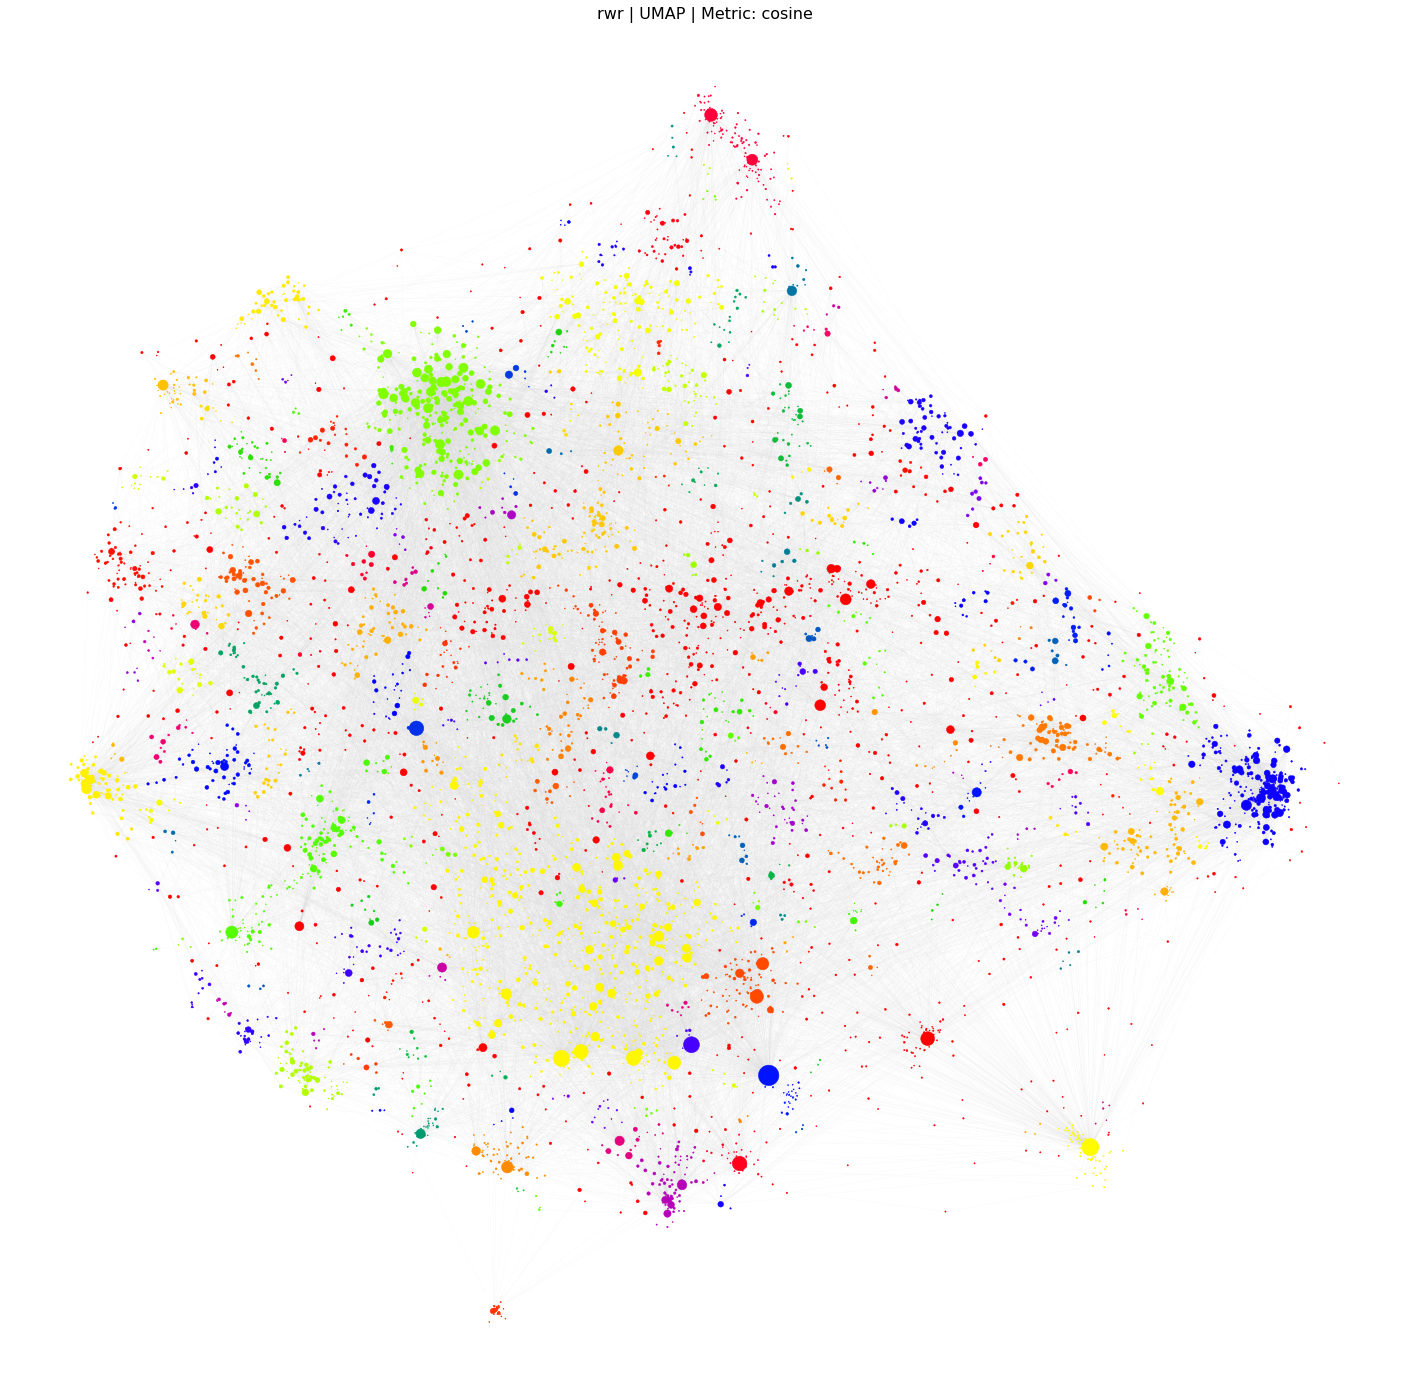

In [404]:
print('Number of Clusters: ', len(set(clusterid.labels_)))
print('Cluster method: ', color_method)

plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_norm, 
                       edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size =  size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_norm,
                       width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2DPortraitumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

#### UMAP EXPORT TO CSV

In [920]:
export_to_csv2D('new2Dportrait_umap_'+feature+'_'+organism, posG_complete_umap_norm, posG_entrez, colours)

____
## 3D PORTRAITS
____

## UMAP

In [405]:
%%time 

n_neighbors = 70 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.001 # defines how dense points are stacked together 
metric='cosine'

umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 2min 26s, sys: 957 ms, total: 2min 27s
Wall time: 26.4 s


In [406]:
# MAIN (if not all G.nodes)
posG_3Dumap = get_posG_3D(genes, umap_3D)

# REST (if genes = G.nodes then rest will be ignored / empty)

# get center of data points
xx=[]
yy=[]
zz=[]

for i in posG_3Dumap.values():
    xx.append(i[0])
    yy.append(i[1])
    zz.append(i[2]) 

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)
cz = sum(zz)/len(genes)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest)) # 2* --> for both halfs of sphere (upper+lower)
theta = pi * (1 + 5**0.5) * indices

xm, ym, zm = max(posG_3Dumap.values())
r = (math.sqrt((cx - xm)**2 + (cy - ym)**2 + (cz - zm)**2))+1 # +10 to ensure all colored nodes are within the sphere
x, y, z = cx+r*cos(theta) * sin(phi),cy+r*sin(theta) * sin(phi), cz+r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dumap, **posG_rest}
posG_3D_complete_umap = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_3D_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

### UMAP CLUSTER Colors (Spectral)

In [426]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3D_complete_umap_norm).T #posG_3Dumap

n_clus = 40
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

print('Number of clusters: ', len(set(clusterid.labels_)))

Number of clusters:  40


### UMAP CLUSTER Colors (DBSCAN)

In [423]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_3D_complete_umap_norm).T #posG_3Dumap

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.05, min_samples=1) 

clusterid = clustering.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = clustering.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

print('Number of clusters: ', len(set(clusterid.labels_)))

Number of clusters:  84


In [427]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_color, opac=0.05)
#umap_edges = get_trace_spec_edges_only(list(d_edge_col.keys()), posG_3D_complete_umap_norm, disease_col)#go_col)

#umap_data = [umap_edges, umap_nodes]
umap_data = [umap_nodes]

CPU times: user 829 ms, sys: 13.1 ms, total: 842 ms
Wall time: 845 ms


In [428]:
print('Number of Clusters: ', len(set(clusterid.labels_)))
print('Cluster method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

data = umap_data
scheme = 'light'
fname = 'output_plots/3Dportrait_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism

plot_3D(data, fname, scheme)

Number of Clusters:  40
Cluster method:  spectral
# Neighbours: 70
Spread: 1.0
Min. Distance: 0.001


'output_plots/3Dportrait_umap_rwr_cosine_spectral_70_1.0_0.001_Yeast.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [889]:
export_to_csv3D('3Dportrait_umap_'+feature+'_'+organism, posG_3D_complete_umap_norm, posG_entrez, colours)

___
## LANDSCAPES
___

### Define z-parameter
+ Choose one of the following
___________

#### ------ STRUCTURAL ------

In [227]:
# dict with geneID : value 
# e.g. Closeness centrality

z_feat = 'clos'

z_list = list(d_clos.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Centrality Metrics average ------

In [429]:
z_feat = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,4)
    
'''d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
dict_z = {key:d_node_bin[key] for key in G.nodes()}'''

dict_z  = {key:d_centr[key] for key in G.nodes()}


z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Disease count ------

In [1621]:
z_feat = 'disease'

DM_feature = DM_Disease
feat_matrix = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)


# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))
    
genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))

# uncomment if binning
'''d_binned = bin_nodes(d_features_counted)

d_functions = {}
for k,v in d_binned.items():
    for each in v:
        d_functions[each] = k'''
        
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = -20
    
d_param_unsorted = {**d_functions , **d_rest}

# comment if binning
d_param_unsorted = {**d_features_counted, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

________

## UMAP

In [430]:
posG_land_umap = {}
cc = 0
for k,v in posG_complete_umap_norm.items():
    posG_land_umap[k] = (v[0],v[1],z_list_norm[cc])
    cc+=1

In [431]:
umap_nodes = get_trace_nodes_3D(posG_land_umap, l_features, colours, size3d)

# choose visibility of edges (all or specific) 
# all
umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_color)
# specific 
#umap_edges = get_trace_spec_edges_only(list(d_edge_col.keys()), posG_land_umap, disease_col)#go_col)

#umap_data = [umap_edges, umap_nodes]
umap_data = [umap_nodes]

In [432]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)

data = umap_data
scheme = 'light'
fname = 'output_plots/Landscapes_umap_'+feature+'_z-'+z_feat+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism

plot_3D(data, fname, scheme)

# Neighbors:  70
Spread:  1.0
Min. Distance:  0.001
Metric:  cosine


'output_plots/Landscapes_umap_rwr_z-centraverage_cosine_spectral_70_1.0_0.001_Yeast.html'

#### UMAP LANDSCAPE EXPORT TO CSV

In [910]:
export_to_csv3D('landscape_umap_'+feature+'_'+organism, posG_land_umap, posG_entrez, colours)

----
## SPHERE
### Define r-parameter
+ Choose one
----

#### ------ Essentiality ------

In [717]:
rad_param = 'essent'

small_rad = 1
middle_rad = 2
outershell_rad = 5


d_ess_scores = {}
for k,e in d_gID_all.items():
    if e == 'E':
        d_ess_scores[k] = outershell_rad 
    elif e == 'NE':
        d_ess_scores[k] = middle_rad
    else:
        d_ess_scores[k] = small_rad

d_param = d_ess_scores

# check how many shells of spheres there will be :
len(set(d_param.values()))

3

#### ------Centrality metrics average ------

In [364]:
rad_param = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[str(i)] = round((j[0]+j[1]+j[2]+j[3])/4,2)

d_param = {key:d_centr[key] for key in G.nodes()}

# check how many shells of spheres there will be :
len(set(d_param.values()))

25

______

In [718]:
n_neighbors = 4 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 # defines how dense points are stacked together 
metric='cosine'

In [719]:
%%time 
umap_sphere = embed_umap_sphere(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 15.7 s, sys: 1.59 s, total: 17.3 s
Wall time: 7.31 s


In [720]:
%%time

genes_new = []
for i in genes:
    if i in G.nodes():
        genes_new.append(i)

posG_3Dsphere = get_posG_sphere(genes_new, umap_sphere)

# setting radius according to d_param selected 

posG_3Dsphere_radius = {}

for node,rad in d_param.items():
    for k,v in posG_3Dsphere.items():
        if k == node:
            posG_3Dsphere_radius[k] = (v[0]*rad, v[1]*rad, v[2]*rad)
            
# REST (if genes = G.nodes then rest will be ignored / empty)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

r = 0.5 # radius for rest genes (e.g. if functional layout)
x, y, z = r*cos(theta) * sin(phi), r*sin(theta) * sin(phi), r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dsphere_radius, **posG_rest}
posG_complete_sphere = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_complete_sphere.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

#posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))
posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(x_list,y_list,z_list)))

KeyError: '66008'

In [721]:
sphere_nodes = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                  1.2 #size3d
                                 )
sphere_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, 
                                  edge_col, #edge_colordark, 
                                  0.1)

#sphere_data = [sphere_edges, sphere_nodes]
sphere_data = [sphere_nodes]

KeyError: '66008'

In [ ]:
data = sphere_data
scheme = 'light'
fname = 'output_plots/3Dsphere_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param

plot_3D(data, fname, scheme)

#### UMAP SPHERE EXPORT TO CSV

In [74]:
export_to_csv3D('sphere_umap_'+feature+'_'+organism+'_'+rad_param, posG_complete_sphere_norm, posG_entrez, colours)

# ===============
# UNDER CONSTRUCTION 

### SPECIFIC COLORING FUNCTIONS

In [323]:
# -------------------------------------------
# DETECTING HUBS 
# and color them + their adjacent neighbours
# -------------------------------------------

# get list of hubs
d_degree = dict(nx.degree(G))


# -------------------------------------------
# CHOOSE TRESHOLDS 
# -------------------------------------------
min_treshold = 300
max_treshold = max(d_degree.values())
# -------------------------------------------

# hubs identified by tresholds 
hubs = {}
for k,v in d_degree.items():
    if v >= min_treshold and v <= max_treshold:
        hubs[k] = v

# get their neighbours
neighbours = {}
hubs_neigh =[]
for i in hubs.keys():
    for edge in G.edges():
        if edge[0] == i:
            hubs_neigh.append(edge[1])
        elif edge[1] == i:
            hubs_neigh.append(edge[0])
        neighbours[i] = hubs_neigh
    
# check for neighbours degree (like if they are only connected to the hub itself, meaning k=1)
neighbours_degs = {}
neigh_degs = []
for key,val in neighbours.items():
    for n in val:
        for k,v in d_degree.items():
            if k == n:
                neigh_degs.append(v)
    neighbours_degs[key] = neigh_degs
    
        
# COLOURING hub nodes and their neighbours 


# -------------------------------------------
# CHOOSE COLOURS
# -------------------------------------------
col_hubs = 'red'
col_neigh = 'orange'
# -------------------------------------------

colours_hubs = {}
for i in G.nodes():
    if i in hubs_neigh:
        colours_hubs[i] = col_neigh
    elif i in hubs:
        colours_hubs[i] = col_hubs
    else: 
        colours_hubs[i] = '#696969' #'dimgrey'
hubs_all_sorted = {key:colours_hubs[key] for key in G.nodes()}

In [283]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [295]:
# -------------------------------------------
# DETECTING BRIDGING NODES 
# and color them + their adjacent neighbours
# -------------------------------------------


# COLOURING betweenness / bridging nodes + all others in grey 

col_betw = 'darkblue'
col_betwneigh = 'mediumblue'

min_tres = 0.06

betw_nodes_col = {}
for k,v in d_betw.items():
    if v >= min_tres:
        betw_nodes_col[k] = col_betw
    else:
        betw_nodes_col[k] = 'lightgrey'


# COLOURING all neighbours of bridging nodes 

betw_neighbours = {}
betw_neigh =[]
for i in betw_nodes.keys():
    for edge in G.edges():
        if edge[0] == i:
            betw_neigh.append(edge[1])
        elif edge[1] == i:
            betw_neigh.append(edge[0])
        betw_neighbours[i] = betw_neigh
        
betw_neigh_col = {}
for key, value in betw_neighbours.items():
    for v in value:
        betw_neigh_col[v] = col_betwneigh
        
betw_all = {**betw_nodes_col, **betw_neigh_col}
betw_all_sorted = {key:betw_all[key] for key in G.nodes()}

In [296]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [ ]:
# T H E O R Y 


# TO DO 


# -------------------------------------------
# DETECTING "PERIPHERAL / ISOLATED" HUBS 
# and color them + their adjacent neighbours
# -------------------------------------------


# check for low degree neighbours : 
neighbours_degs_filtered = {}
for k,v in neighbours_degs.items():
    if v <= 2:
        neighbours_degs_filtered[k] = v

In [ ]:
# V I S U A L 


# TO DO  
# - edge opacity 
# - node opacity 



# TO DO FOR WEBAPP 
# make gene list as input for the color functions 
# to choose like: (WEBAPP) 

# input gene list
# choose major color
# choose if neighbours shall also be coloured > then choose their color too

# opacity of nodes will be affected by that (most visible = major, least = none) 
# opcacity of edges !!!! 



# TO DO  : 
# - revive old hubs colouring function > where each hubs would come out as different color
# edge colouring there too ??? 

In [ ]:
# TOGGLE colour method: 

# ------------------
# HUB NODES 
# ------------------
color_method = 'hubs'
colours = list(hubs_all_sorted.values())


# ------------------
# PERIPHERAL HUB
# ------------------
#color_method = 'isol_hubs'



# ------------------
# BETWEENNESS NODES (bridging nodes)
# ------------------
#color_method = 'betw'
#colours = list(betw_all_sorted.values())

# ==============

# Sphere Colours based on Clusters

### UMAP CLUSTER Colors (Spectral)

In [1332]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3Dsphere_radius).T
genes = genes_new 

n_clus = 30
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'Set1')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



### UMAP CLUSTER Colors (DBSCAN)

In [167]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_sphere_norm).T

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.5, min_samples=10) 

clusterid = clustering.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes_new, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {str(key):colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())